## App Store Reivew analysis - Hwahae
---------------

## 개요

### 문서 목적
- Socar에서 서비스 중인 튜터링(tutoring) 앱에 대한 분석 리포트 작성을 위해 문서를 만들었습니다.

### 분석 대상
- **구글 플레이 스토어에 고객이 작성한 리뷰 정보**
  - user_name : 이용자 이름(닉네임)
  - user_app_rating : 별점(1~5)
  - user_review_date : 리뷰 작성 날짜
  - company_comment_date : 버드뷰 답변 작성 날짜
  - user_simple_comment : 리뷰 내용
  - user_specific_comment : 리뷰 상세 내용
    - user_simple_comment의 내용이 길 경우 웹 상에서 다 보이지 않고 상세하게 볼 수 있도록 구성되어 있어 추가한 항목입니다. 전처리를 통해 처리 될 예정입니다.
  - company_answer_check : 버드뷰 답변 여부


### 분석 일시
- 크롤링 데이터 구성 시간 : 2019년 07월 13일 14시
- 데이터 분석 시작 : 2019년 07월 13일 20시

### 분석 방법
1. 데이터 확인
  - 데이터 전처리
  - 컬럼 확인
2. 시간 기록에 따른 데이터 분석
  - 시간에 따른 별점 변화(별점은 1 ~ 5의 값을 가진다)
  - 요일에 따른 리뷰 분석
  - 답변 시간차(고객 응대 소요 시간)
3. 리뷰 내용에 대한 자연어 분석
  - 리뷰 내용을 Topic modeling로 구성하고 시각화
  - 별점에 따라 주요 키워드 분석 진행

### 분석 환경, 분석자
- 분석 환경
  - language
      - python3
  - library
      - [khaiii](https://github.com/kakao/khaiii) : 카카오에서 제공하는 형태소 분석기
      - [gensim](https://radimrehurek.com/gensim/) : 자연어 처리 방법 중 LDA - Topic Modeling 사용
      - 시각화, 데이터 분석을 위한 기본 library

- 분석자
  - github : https://github.com/timetobye


### 안내 사항
- **분석에 사용 될 리뷰 정보는 직접 크롤링**을 하여 데이터 셋을 구성하였습니다.
- 2018년 10월 한국 시장 기준으로 Android(72.2%) vs IOS(27.8%)의 점유율을 갖고 있어서 구글 플레이 스토어를 선택하였습니다.
  - [참고 링크 - Difference in Mobile OS Market Share is notable in US, Japan and South Korea](https://en.appa.pe/whitepaper/2018/)
  
--------------------------------------------

### 분석 결과
----------------

### code

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.style as style
import seaborn as sns
import khaiii
import missingno as msno
import warnings
import re
import calendar
import gensim
import os
from collections import Counter
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.models import LdaModel
from pyLDAvis import gensim as gensimvis
from pyLDAvis import display
from pyLDAvis import save_html as lda_visualization
from khaiii import KhaiiiApi
from matplotlib import font_manager, rc
apple = font_manager.FontProperties(fname = '/Library/Fonts/AppleGothic.ttf').get_name()
rc('font', family = apple)

warnings.filterwarnings('ignore')
style.use('fivethirtyeight')
%matplotlib inline

## 1. 데이터 확인

### 데이터 전처리 - Preprocessing

In [2]:
# read_csv to make dataframe

google_playstore_user_review_orginal_df = pd.read_csv('review_data/socar_app_user_reviews_2019-07-15.csv')
google_playstore_user_review_orginal_df.head(10)

,user_name,user_app_rating,user_review_date,company_comment_date,user_simple_comment,user_specific_comment,company_answer_check
0,빰톨,1,2019년 7월 10일,no_answer,와~ 스트레스 쌓이게 하는 업데이트네요. 시간 설정하면 극강의 짜증이 옵니다. 시간...,no_specific_comment,no_answer
1,piaDIK,3,2019년 7월 4일,no_answer,저번에 완전 리뉴얼하면서 어플을 다운그레이드 한후 지속적인 업데이트를 통해 많은 부...,no_specific_comment,no_answer
2,가지가지,1,2019년 7월 9일,no_answer,진심으로 구번전으로 복귀할 수 있는 방법 없을까요..? 뭐지 이 새로운 앱은... ...,no_specific_comment,no_answer
3,박해식,1,2019년 7월 6일,no_answer,고객센터 일처리 드럽게 한다!! 쏘카존 갔는데 있어야 할차는 없고 차량을 나보고 못...,고객센터 일처리 드럽게 한다!! 쏘카존 갔는데 있어야 할차는 없고 차량을 나보고 못...,no_answer
4,Ray Jang,1,2019년 7월 15일,no_answer,정기구독 해지할까 고민중이네요. 몇년간 정말 잘 사용했는데 요새 차량 관리도 정말 ...,no_specific_comment,no_answer
5,홍길주,1,2019년 7월 15일,no_answer,쏘카 자체는 좋음. 다만 앱이 문제임. 직관적이지 않고 그지같음. 뭘 눌러야 내가 ...,no_specific_comment,no_answer
6,S뽀로로,4,2019년 7월 14일,no_answer,주유량 미리보기는 왜 없앴나요,no_specific_comment,no_answer
7,OCTOBER JAIMY,1,2019년 7월 13일,no_answer,반납장소선택이왜안돼요? 왕복인지편도인지선택좀..,no_specific_comment,no_answer
8,손주노,1,2019년 7월 12일,no_answer,업데이트장난하나 구버젼보다 더 불편하자나 이건적응하는걸떠나서 하 이걸 업뎃승인한간부...,no_specific_comment,no_answer
9,튼튼천안호두,1,2019년 7월 12일,no_answer,타지마세요 1등 카셰어링이라 되어잇는데 속는겁니다 고객센터 대응하면 앞뒤없이 본인과...,no_specific_comment,no_answer


In [3]:
# check dataframe info

google_playstore_user_review_orginal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3404 entries, 0 to 3403
Data columns (total 7 columns):
user_name                3404 non-null object
user_app_rating          3404 non-null int64
user_review_date         3404 non-null object
company_comment_date     3404 non-null object
user_simple_comment      3404 non-null object
user_specific_comment    3404 non-null object
company_answer_check     3404 non-null object
dtypes: int64(1), object(6)
memory usage: 186.2+ KB


### check-point

- 크롤링 과정에서도 첫 3개가 시간 순서 정렬과 관계없이 항상 고정된 값으로 구성되어 있었다.
  - 해당 부분에 대해서는 날짜 기준으로 정렬할 것
- 중복 값이 있는 경우를 방지하기 위해 중복 체크도 진행한다.
- 날짜 정보도 사용하기 쉽게 YYYY-MM-DD 형식으로 처리 할 것
- 요일 정보를 얻기 위해 작업을 진행 할 것
- user의 comment를 정리하기 위해 user_comment 컬럼을 추가하고 아래와 같이 진행
  - user_specific_comment가 있을 경우 user_comment로 처리
  - user_specific_comment가 없을 경우 user_simple_comment가 user_comment로 처리


In [4]:
def sort_dataframe(df):
    sorted_df = df.sort_values(by='user_review_date', ascending=False).reset_index(drop=True)
    
    return sorted_df

def drop_duplicate_dataframe(df):
    drop_dp_df = df.drop_duplicates()
    drop_dp_df.reset_index(drop=True, inplace=True)
    
    return drop_dp_df

def get_weekday(date):
    if date == 'no_answer':
        return date
    
    weekday_info_dict = {
        0 : 'Mon',
        1 : 'Tue',
        2 : 'Wed',
        3 : 'Thu',
        4 : 'Fri',
        5 : 'Sat',
        6 : 'Sun'
    }
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)
    
    year, month, day = [int(value) for value in get_regex_date]
    
    weekday_number = calendar.weekday(year, month, day)
    weekday_value = weekday_info_dict[weekday_number]
    
    return weekday_value

def convert_date_format(date):
    if date == 'no_answer':
        return date
    
    regex = re.compile(r'[0-9]+')
    get_regex_date = regex.findall(date)

    if len(get_regex_date[1]) == 1:
        get_regex_date[1] = '0' + get_regex_date[1]
        
    if len(get_regex_date[2]) == 1:
        get_regex_date[2] = '0' + get_regex_date[2]
    
    join_string = '-'
    convert_date = join_string.join(get_regex_date)
    
    return convert_date

def arrange_user_comment(df):
    user_comment = []
    
    for index, row in df.iterrows():    
        if row['user_specific_comment'] == 'no_specific_comment':
            user_comment.append(row['user_simple_comment'])
        else:
            user_comment.append(row['user_specific_comment'])

    df['user_comment'] = user_comment
    df.drop(['user_simple_comment', 'user_specific_comment'], axis=1, inplace=True)
    df = df[['user_name', 'user_app_rating', 'user_review_date', 'company_comment_date', 'user_review_weekday', 'user_comment', 'company_answer_check']]
    
    return df

def user_data_preprocessing(google_playstore_user_review_orginal_df):
    # sort user_review_date
    sorted_user_review_df = sort_dataframe(google_playstore_user_review_orginal_df)

    # drop duplicate
    drop_dp_user_review_df = drop_duplicate_dataframe(sorted_user_review_df)

    # get weekday from user_review_date
    drop_dp_user_review_df['user_review_weekday'] = drop_dp_user_review_df['user_review_date'].apply(get_weekday)

    # convert_date_format for applying function in pandas
    drop_dp_user_review_df['user_review_date'] = drop_dp_user_review_df['user_review_date'].apply(convert_date_format)
    drop_dp_user_review_df['company_comment_date'] = drop_dp_user_review_df['company_comment_date'].apply(convert_date_format)

    # arrange_user_comment
    arranged_user_review_df = arrange_user_comment(drop_dp_user_review_df)
    
    return arranged_user_review_df

In [5]:
arranged_user_review_df = user_data_preprocessing(google_playstore_user_review_orginal_df)
arranged_user_review_df.head()

,user_name,user_app_rating,user_review_date,company_comment_date,user_review_weekday,user_comment,company_answer_check
0,가지가지,1,2019-07-09,no_answer,Tue,진심으로 구번전으로 복귀할 수 있는 방법 없을까요..? 뭐지 이 새로운 앱은... ...,no_answer
1,거프,1,2019-07-08,no_answer,Mon,쏘카앱처음이용해볼려고 깔았는데 사용하기 너무어렵네요.. 그냥 집앞에 렌터카 이용해야...,no_answer
2,이대우,1,2019-07-08,no_answer,Mon,이런 어처구니없는 경우가 키로당 추가요금이 뭔가했더니 어느정도 상한선이있어야지 차량...,no_answer
3,Gooyong Lee,5,2019-07-08,no_answer,Mon,좋아요 좋아요,no_answer
4,hj k,1,2019-07-07,no_answer,Sun,가격을 보지마시고 정산후 거리당 추가요금 생각하세요 집 근처 렌트카 7만에 빌릴거 ...,no_answer


--------------------------------

## Basic EDA

### check data info & missingvalue

In [6]:
arranged_user_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3399 entries, 0 to 3398
Data columns (total 7 columns):
user_name               3399 non-null object
user_app_rating         3399 non-null int64
user_review_date        3399 non-null object
company_comment_date    3399 non-null object
user_review_weekday     3399 non-null object
user_comment            3399 non-null object
company_answer_check    3399 non-null object
dtypes: int64(1), object(6)
memory usage: 186.0+ KB


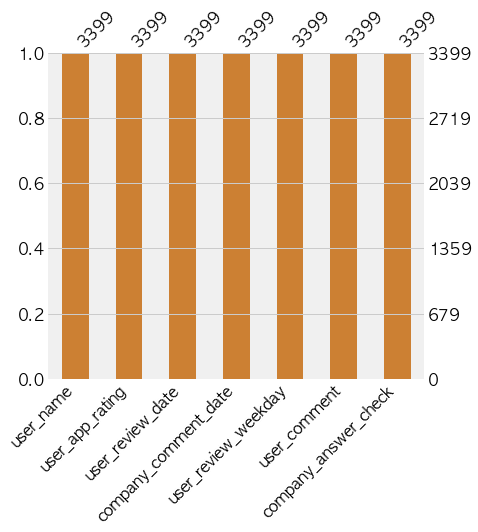

In [7]:
#msno.bar

msno.bar(df=arranged_user_review_df.iloc[:, :], figsize=(6, 6), color=(0.8, 0.5, 0.2))
plt.show()

### 수집된 데이터의 기간

In [8]:
max_date = arranged_user_review_df['user_review_date'].max()
min_date = arranged_user_review_df['user_review_date'].min()

print(f'수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 {min_date} 부터 {max_date} 까지 입니다.')

수집된 데이터를 살펴보니 이용자가 리뷰를 작성한 날짜는 2018-06-09 부터 2019-07-15 까지 입니다.


### 리뷰를 작성한 사람들은 누구일까요?

In [9]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('user').reset_index(name='writing_count')
    sorted_df_count = df_count.sort_values('writing_count', ascending=False)
    arranged_df = sorted_df_count.reset_index(drop=True)

    return arranged_df

In [10]:
arrange_count_df = arrange_count_value(arranged_user_review_df, 'user_name')
arrange_count_df.head(10)

,user,writing_count
0,Google 사용자,462
1,김민수,6
2,김영민,4
3,이동현,4
4,김도현,4
5,김태현,4
6,정유진,3
7,김태호,3
8,김진석,3
9,이주성,3


- **Google 사용자**가 다수가 나온 이유를 살펴보니, 앱스토어에서 실제로 리뷰 작성자의 이름이 Google 사용자라고 되어 있다.
  - 탈퇴를 했거나, 혹은 익명의 아이디를 처리하는 방식으로 판단된다.
  - 결론적으로 Google 사용자를 잠시 제외하고 살펴보겠다.

In [11]:
drop_arrange_count_df = arrange_count_df.drop(index=0).reset_index(drop=True)

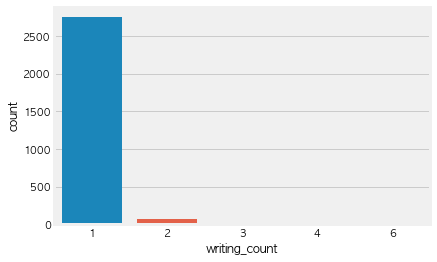

In [12]:
# 이용자들은 개인당 몇 번이나 리뷰를 달았을까?

sns.countplot(x='writing_count', data = drop_arrange_count_df)

In [13]:
groupby_user_review_count = drop_arrange_count_df.groupby('writing_count', as_index=False).count()
groupby_user_review_count.rename(columns = {'user' : 'count'}, inplace=True)
groupby_user_review_count['ratio'] = round(groupby_user_review_count['count']/sum(groupby_user_review_count['count']), 2)
groupby_user_review_count

,writing_count,count,ratio
0,1,2748,0.97
1,2,70,0.02
2,3,9,0.00
3,4,4,0.00
4,6,1,0.00


- 96%이상의 이용자가 1번 정도의 리뷰를 달았고, 소수의 이용자가 2~3번 리뷰를 달은 것으로 파악된다.

### 어떤 요일에 많이 달았을까?

In [14]:
weekday_count = arrange_count_value(arranged_user_review_df, 'user_review_weekday')
weekday_count.rename(columns={'user' : 'weekday'}, inplace=True)

In [15]:
weekday_count

,weekday,writing_count
0,Sat,537
1,Sun,518
2,Fri,505
3,Thu,497
4,Wed,486
5,Tue,460
6,Mon,396


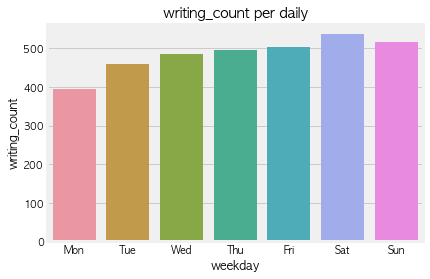

In [16]:
# draw weekday graph

weekday_order_list = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
sns.barplot(x='weekday', y='writing_count', data=weekday_count, order=weekday_order_list)
plt.title('writing_count per daily')
plt.show()

- 간략하게 살펴본 결과 **일요일**이 가장 높은 리뷰 작성일인 것을 보여주고 있다.
- 좀 더 상세하게 살펴볼 필요도 있을 것 같다.

### 별점 분포는 어떻게 되어 있을까?

In [17]:
app_rating_count = arrange_count_value(arranged_user_review_df, 'user_app_rating')
app_rating_count.rename(columns={'user' : 'app_rating', 'writing_count' : 'rating_count'}, inplace=True)
app_rating_count

,app_rating,rating_count
0,5,1895
1,1,714
2,4,495
3,3,200
4,2,95


In [18]:
app_rating_count['ratio'] = round(app_rating_count['rating_count']/sum(app_rating_count['rating_count']), 2)
app_rating_count

,app_rating,rating_count,ratio
0,5,1895,0.56
1,1,714,0.21
2,4,495,0.15
3,3,200,0.06
4,2,95,0.03


Text(0.5, 1.0, 'app rating count')

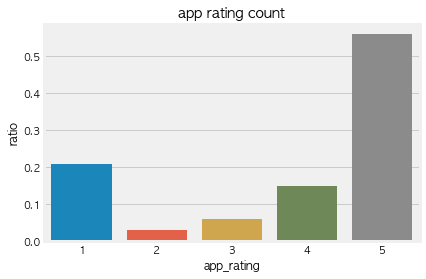

In [19]:
# draw app_rating graph

app_rating_order_list = [1, 2, 3, 4, 5]
sns.barplot(x='app_rating', y='ratio', data=app_rating_count, order=app_rating_order_list)
plt.title('app rating count')

- 5점 61% , 4점 14%, 3점 8%, 2점 5%, 1점 12% 을 이용자들은 리뷰로 남겼다.
- 화해의 특성에 알맞게 5점이 대다수를 이루고 있으나, 1점을 준 사람도 3번째로 높은 비중을 남겼다.
  - 1점~2점을 남긴 사람에 대한 리뷰 코멘트가 달렸는지 확인해보면 고객 대응 정도를 확인 할 수 있을 것 같다.

-----------------------

## 2. 시간 기록에 따른 데이터 분석

### 시간에 따른 별점 변화

- 여러가지 접근 방법이 있겠지만, 일별 평균 별점 값을 그래프로 그려서 확인해본다.
- 2019년 07월 13일 기준, 화해의 구글 플레이 스토어 별점은 4.7점이다.
- 그래프를 그렸으나 그래프에 표현되는 값이 너무 많은 관계로 2019년 값만 그리도록 하겠습니다.

In [20]:
app_rating_with_date = arranged_user_review_df[['user_app_rating', 'user_review_date']]
average_app_rating_per_daily = app_rating_with_date.groupby('user_review_date', as_index=False).mean()
average_app_rating_per_daily = average_app_rating_per_daily[average_app_rating_per_daily['user_review_date']>='2019-01-01']
app_rating_with_date.head()

,user_app_rating,user_review_date
0,1,2019-07-09
1,1,2019-07-08
2,1,2019-07-08
3,5,2019-07-08
4,1,2019-07-07


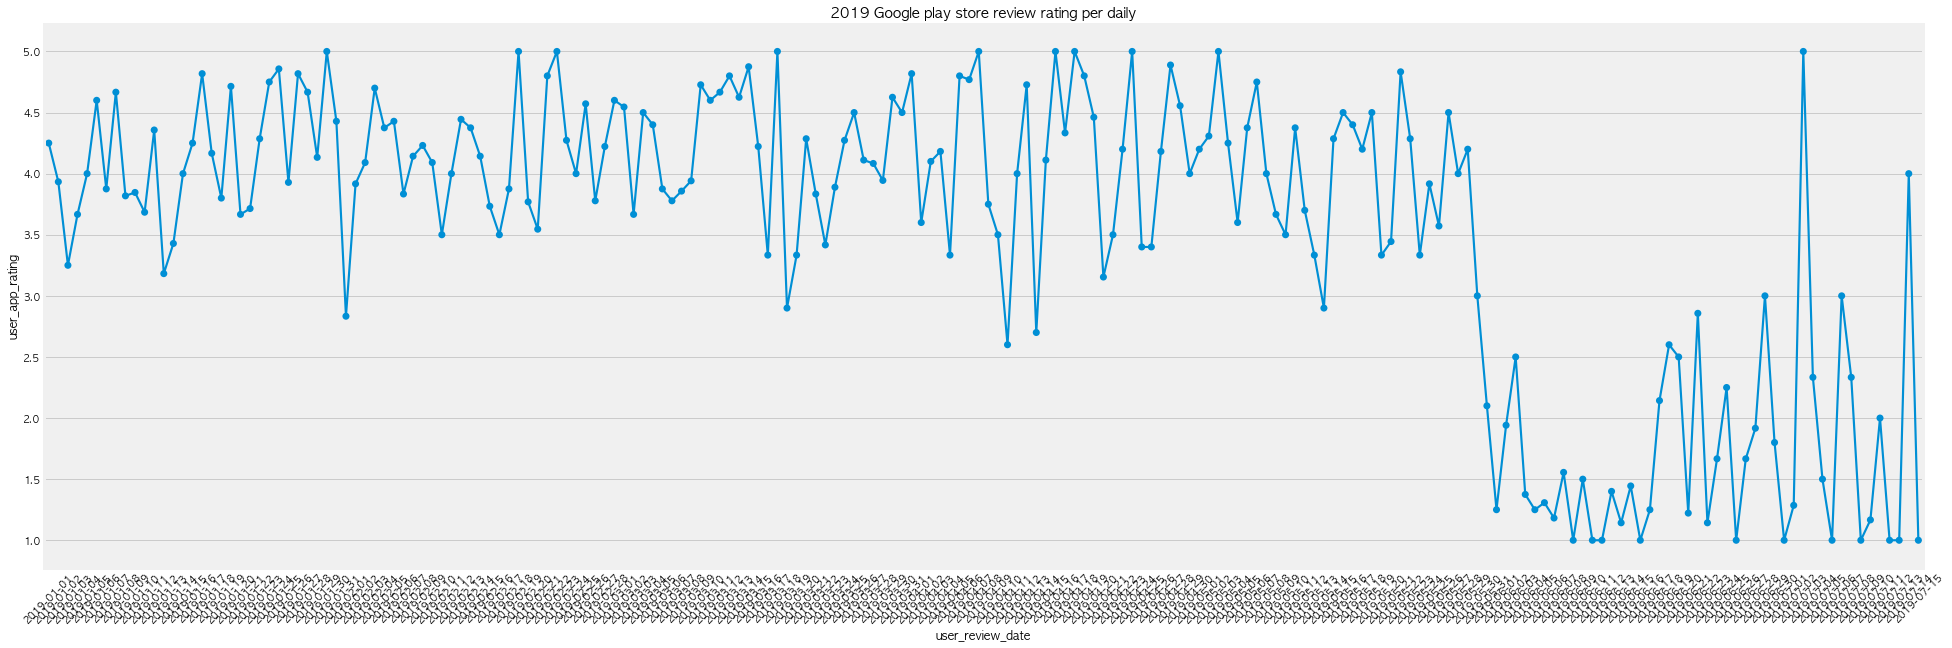

In [21]:
# draw graph : 2019 Google play store review rating per daily

plt.figure(figsize = (30, 10))
sns.pointplot(x='user_review_date', y='user_app_rating', data=average_app_rating_per_daily, scale=0.3)
plt.xticks(rotation=45)
plt.title('2019 Google play store review rating per daily')
plt.show()

In [22]:
# check app rating == 1

average_app_rating_per_daily[average_app_rating_per_daily['user_app_rating']==1]

,user_review_date,user_app_rating
365,2019-06-09,1.0
367,2019-06-11,1.0
368,2019-06-12,1.0
372,2019-06-16,1.0
382,2019-06-26,1.0
387,2019-07-01,1.0
392,2019-07-06,1.0
395,2019-07-09,1.0
398,2019-07-12,1.0
399,2019-07-13,1.0


In [23]:
app_rating_with_date[app_rating_with_date['user_review_date']=='2019-04-02']

,user_app_rating,user_review_date
617,5,2019-04-02
618,1,2019-04-02
619,3,2019-04-02
620,4,2019-04-02
621,5,2019-04-02


In [24]:
app_rating_with_date[app_rating_with_date['user_review_date']=='2019-04-30']

,user_app_rating,user_review_date
601,1,2019-04-30
602,5,2019-04-30
603,5,2019-04-30
604,5,2019-04-30
605,5,2019-04-30
606,1,2019-04-30
607,4,2019-04-30
608,4,2019-04-30
609,1,2019-04-30
610,5,2019-04-30


In [25]:
# check statics

app_rating_with_date.describe()

,user_app_rating
count,3399.000000
mean,3.812592
std,1.607591
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


- 전체적으로 높은 별점을 보이고 있으나, 종종 낮은 별점을 가지는 경우가 있다.
- 1점을 가진 경우를 살펴보니, 일일 1명이 평가한 점수였다.
- 실제 이용자들의 앱 사용 리뷰에 대한 평가는 등락은 있으나 데이터 셋 기준으로는 4.06점을 나타내고 있다.
  - 앱 초기부터 현재까지의 데이터를 모을 수 있으면 좀 더 변화가 있는 정보를 얻을 수 있을 것 같다.
- 관점을 바꿔서 월별 분석을 해보도록 한다.

### 월별 분석
- 월별 분석을 위해 간단한 전처리 진행 후 분석한다.
  - 단, 월별 분석 과정에서 한 달을 완전히 보존하기 위해 2017년 10월 01일 부터 2019년 06월 30일까지로 한정한다.

In [26]:
app_rating_with_monthly = arranged_user_review_df[['user_app_rating', 'user_review_date']]
app_rating_with_monthly.head()

,user_app_rating,user_review_date
0,1,2019-07-09
1,1,2019-07-08
2,1,2019-07-08
3,5,2019-07-08
4,1,2019-07-07


In [27]:
def extract_year_month(date):
    year_month = date[0:7]
    
    return year_month

In [28]:
app_rating_with_monthly['year_month'] = app_rating_with_monthly['user_review_date'].apply(extract_year_month)
app_rating_with_monthly.head()

,user_app_rating,user_review_date,year_month
0,1,2019-07-09,2019-07
1,1,2019-07-08,2019-07
2,1,2019-07-08,2019-07
3,5,2019-07-08,2019-07
4,1,2019-07-07,2019-07


In [29]:
app_rating_with_year_month = app_rating_with_monthly[(app_rating_with_monthly['year_month']>='2017-10')&(app_rating_with_monthly['year_month']<='2019-06')]
app_rating_with_year_month.sort_values('user_review_date', ascending=False, inplace=True)
app_rating_with_year_month.reset_index(drop=True, inplace=True)

In [30]:
app_rating_with_year_month.head()

,user_app_rating,user_review_date,year_month
0,1,2019-06-30,2019-06
1,1,2019-06-30,2019-06
2,1,2019-06-30,2019-06
3,3,2019-06-30,2019-06
4,3,2019-06-30,2019-06


In [31]:
monthly_result = app_rating_with_year_month.groupby('year_month', as_index=False).mean()
monthly_result

,year_month,user_app_rating
0,2018-06,3.809524
1,2018-07,3.739777
2,2018-08,3.747368
3,2018-09,3.990000
4,2018-10,4.090909
5,2018-11,4.041667
6,2018-12,4.220000
7,2019-01,4.092105
8,2019-02,4.092251
9,2019-03,4.153846


In [32]:
monthly_result.describe()

,user_app_rating
count,13.000000
mean,3.808747
std,0.685300
min,1.593074
25%,3.809524
50%,4.041667
75%,4.092251
max,4.220000


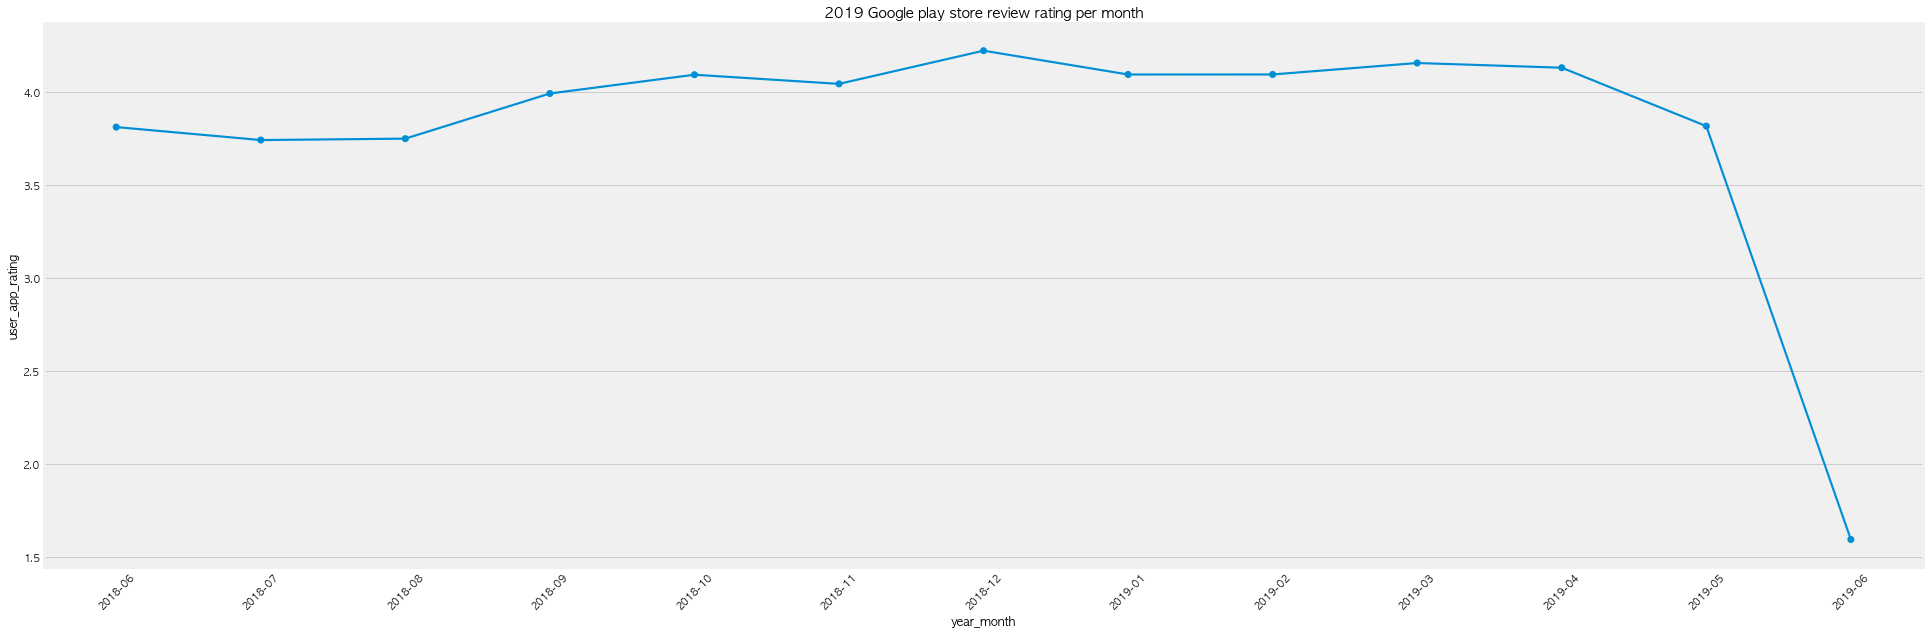

In [33]:
# draw graph : 2019 Google play store review rating per month

plt.figure(figsize = (30, 10))
sns.pointplot(x='year_month', y='user_app_rating', data=monthly_result, scale=0.3)
plt.xticks(rotation=45)
plt.title('2019 Google play store review rating per month')
plt.show()

- 2018-09를 제외하고는 3.7이상의 월별 별점 평균을 보이고 있습니다.
- 전반적으로 높은 별점을 월별 기록하고 있으며, 여름 성수기와 12월에 높은 별점을 받고 있습니다.

## 요일에 따른 리뷰 분석

In [34]:
weekday_user_review_df = arranged_user_review_df[['user_app_rating', 'user_review_weekday']]
weekday_user_review_df.head()

,user_app_rating,user_review_weekday
0,1,Tue
1,1,Mon
2,1,Mon
3,5,Mon
4,1,Sun


In [35]:
# crosstab for checking two catagory

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], margins=True).style.background_gradient(cmap='summer_r')
crosstab_result

user_review_weekday,Fri,Mon,Sat,Sun,Thu,Tue,Wed,All
user_app_rating,,,,,,,,
1,114,72,106,106,116,114,86,714
2,20,8,13,11,13,13,17,95
3,34,21,32,36,32,19,26,200
4,68,56,86,84,63,63,75,495
5,269,239,300,281,273,251,282,1895
All,505,396,537,518,497,460,486,3399


In [36]:
# crosstab with ratio

crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
crosstab_result

user_app_rating,1,2,3,4,5
user_review_weekday,,,,,
Fri,0.033539,0.005884,0.010003,0.020006,0.079141
Mon,0.021183,0.002354,0.006178,0.016475,0.070315
Sat,0.031186,0.003825,0.009415,0.025302,0.088261
Sun,0.031186,0.003236,0.010591,0.024713,0.082671
Thu,0.034128,0.003825,0.009415,0.018535,0.080318
Tue,0.033539,0.003825,0.005590,0.018535,0.073845
Wed,0.025302,0.005001,0.007649,0.022065,0.082966


In [37]:
def draw_heatmap(weekday_user_review_df, weekday_order_list):
    crosstab_result = pd.crosstab(weekday_user_review_df['user_app_rating'], weekday_user_review_df['user_review_weekday'], normalize=True).T
    crosstab_result = crosstab_result.reindex(index=weekday_order_list)
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(crosstab_result, cmap="YlGnBu", annot=True, cbar=True, fmt='0.3g')
    plt.title('user_app_rating per weekday')
    plt.show()

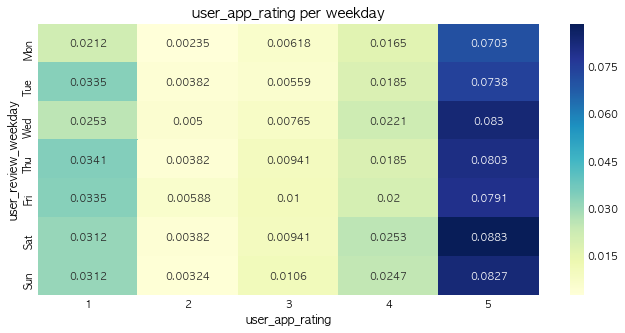

In [38]:
draw_heatmap(weekday_user_review_df, weekday_order_list)

- 일요일에 가장 많은 리뷰 횟수가 기록되면서, 5점 리뷰도 가장 많이 기록되고 있는 것으로 파악된다.
- 화요일에 가장 적은 리뷰 횟수가 기록되며, 높은 리뷰 점수 비중도 다른 날에 비해 상대적으로 낮다.
  - 이용자들이 화장품 앱을 며칠간 사용하고, 사용 시간과 리뷰를 남길 수 있는 시간이 겹치는 영역이 일요일로 파악된다.
  - 트래픽을 확인 할 수는 없으나, 일요일을 타깃으로 이용자들과 호흡할 수 있는 이벤트도 검토해볼만하다.

---------------------------------

### 고객 응대 소요 시간
- 버드뷰에서 이용자들에게 답변하는 날짜는 이용자가 리뷰를 달은 날짜와 얼마나 차이가 날까?
  - 답변을 달지 않은 날은 제외하고 파악해보도록 하자
  - 아쉽게도 시, 분, 초는 플레이스토어에서 구할 수가 없어서 day 기준으로 판단한다.
- 리플을 굳이 달지 않아도 되는 항목이 있을 수도 있으니, 리플을 달은 것 vs 달지 않은 것에 대한 비교는 하지 않는다.

In [39]:
reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_answer = reply_date_df[reply_date_df['company_comment_date']!='no_answer'].reset_index(drop=True)
reply_date_df_with_answer.head()

,user_app_rating,user_review_date,company_comment_date
0,1,2019-07-02,2019-06-25
1,1,2019-07-11,2018-10-31
2,4,2019-07-11,2019-06-11
3,1,2019-06-09,2019-06-11
4,1,2019-06-09,2019-06-11


In [40]:
def convert_string_to_datetime_format(date):
    convert_date = datetime.strptime(date, "%Y-%m-%d")
    
    return convert_date


def calculate_time_deleta(df, column_name_1, column_name2):
    time_delta_list = []
    for index, row in df.iterrows():
        time_delta_value = row[column_name2] - row[column_name_1]
        time_delta_day = time_delta_value.days
        
        time_delta_list.append(time_delta_day)
        
    df['reply_time'] = time_delta_list
    
    return df

In [41]:
# convert string to datetime_format

reply_date_df_with_answer_columns = ['user_review_date', 'company_comment_date']

for column in reply_date_df_with_answer_columns:
    reply_date_df_with_answer[column] = reply_date_df_with_answer[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_answer, 'user_review_date', 'company_comment_date')
cal_reply_time_delta_df.head()

,user_app_rating,user_review_date,company_comment_date,reply_time
0,1,2019-07-02,2019-06-25,-7
1,1,2019-07-11,2018-10-31,-253
2,4,2019-07-11,2019-06-11,-30
3,1,2019-06-09,2019-06-11,2
4,1,2019-06-09,2019-06-11,2


In [42]:
def arrange_count_value(df, column_name):
    df_value_count = df[column_name].value_counts()
    
    df_count = df_value_count.rename_axis('reply_time').reset_index(name='count')
    sorted_df_count = df_count.sort_values('reply_time', ascending=True)
    arranged_df = sorted_df_count.reset_index(drop=True)
    arranged_df = sorted_df_count[sorted_df_count['reply_time']>=0].reset_index(drop=True)
    
    return arranged_df

In [43]:
# 답변 시간이 음수가 되는 경우가 종종 있다. 
# 시스템 문제로 파악 되었으나, 그게 아니고 하나의 글에 리플을 여러번 달 경우 처음 답변과의 시차가 발생해서 나타난 결과이다.
# 이번 분석에서는 음수가 되는 경우는 제외하고 시각화 하겠다.

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df

,reply_time,count,ratio,cumsum_ratio
0,0,179,0.069731,0.069731
1,1,362,0.141021,0.210752
2,2,369,0.143748,0.354499
3,3,347,0.135177,0.489677
4,4,309,0.120374,0.610051
5,5,269,0.104792,0.714842
6,6,194,0.075575,0.790417
7,7,157,0.061161,0.851578
8,8,109,0.042462,0.894040
9,9,56,0.021815,0.915855


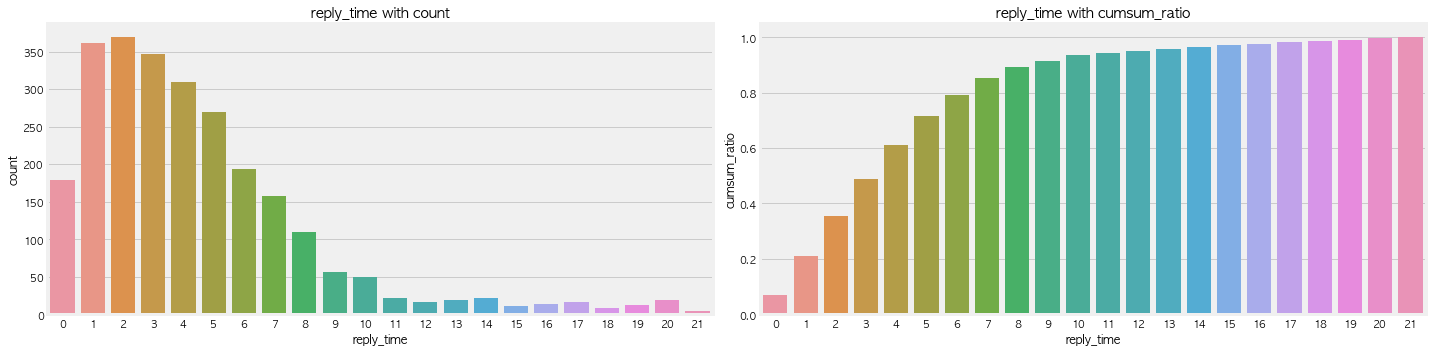

In [44]:
# draw reply_time graph
def draw_count_and_ratio_graph(df):
    y_position = 1.02
    f, ax = plt.subplots(1,2, figsize=(20, 5))

    sns.barplot(x='reply_time', y='count', data=df, ax=ax[0])
    ax[0].set_title(f'reply_time with count')

    sns.barplot(x='reply_time', y='cumsum_ratio', data=df, ax=ax[1])
    ax[1].set_title(f'reply_time with cumsum_ratio')
    
    plt.tight_layout()
    plt.show()

draw_count_and_ratio_graph(reply_time_df)

- 별점에 관계없이 답변이 달린 경우는 리뷰가 달린 날짜 대비 3일 이내에 80% 이상 답변이 달리고 있다.
- 그렇다면 별점이 낮은(1점, 2점)의 경우 어떻게 달리고 있을까? 예상하기로는 전체 답변 달리는 것과 동일한 경향을 보일 것이다.

In [45]:
# filter data set

reply_date_df = arranged_user_review_df[['user_app_rating', 'user_review_date', 'company_comment_date']]
reply_date_df_with_low_rating = reply_date_df[(reply_date_df['company_comment_date']!='no_answer')&(reply_date_df['user_app_rating']<=2)].reset_index(drop=True)
reply_date_df_with_low_rating.head()


# convert string to datetime_format

reply_date_df_with_low_rating_columns = list(reply_date_df_with_low_rating.columns)

for column in reply_date_df_with_low_rating_columns:
    if column == "user_app_rating":
        continue

    reply_date_df_with_low_rating[column] = reply_date_df_with_low_rating[column].apply(convert_string_to_datetime_format)
    

# calculate time delta

cal_reply_time_delta_df = calculate_time_deleta(reply_date_df_with_low_rating, 'user_review_date', 'company_comment_date')


# calculate ratio

reply_time_df = arrange_count_value(cal_reply_time_delta_df, 'reply_time')
reply_time_df['ratio'] = reply_time_df['count'] / sum(reply_time_df['count'])
reply_time_df['cumsum_ratio'] = reply_time_df['ratio'].cumsum()
reply_time_df

,reply_time,count,ratio,cumsum_ratio
0,0,39,0.106267,0.106267
1,1,62,0.168937,0.275204
2,2,53,0.144414,0.419619
3,3,56,0.152589,0.572207
4,4,54,0.147139,0.719346
5,5,35,0.095368,0.814714
6,6,24,0.065395,0.880109
7,7,12,0.032698,0.912807
8,8,11,0.029973,0.942779
9,9,6,0.016349,0.959128


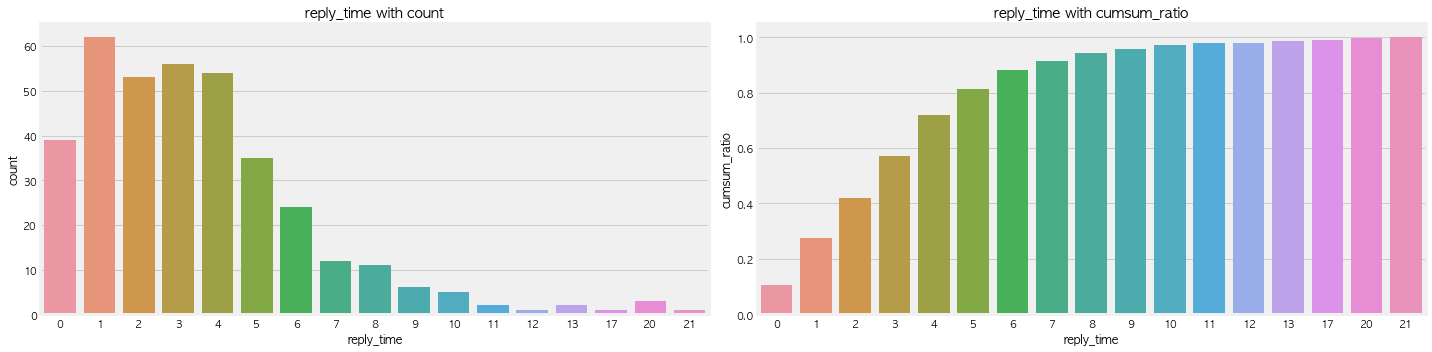

In [46]:
draw_count_and_ratio_graph(reply_time_df)

- 전체 경향과 유사하게 3일 이내에 80%의 답변이 달리고 있는 것을 확인 할 수 있다.
------------------------

### 3. 리뷰 내용에 대한 자연어 간단 분석
- KAKAO KHAiii를 이용하여 명사 추출
- 추출된 자료를 바탕으로 Topic modeling로 구성하고 시각화
- 별점에 따라 주요 키워드 분석 진행

In [47]:
def extract_noun(word_object_list):
    extracted_word_noun_list = []
    
    for i, word_object in enumerate(word_object_list):
        word_object_morphs = word_object.morphs
        
        for word in word_object_morphs:
            if word.tag in ['NNG', 'NNP']:
                extracted_word_noun_list.append(word.lex)
    
    return extracted_word_noun_list


def execute_khaiii(user_comment_list):
    sentence_analyze_components = []
    kha_api = KhaiiiApi()
    
    for i, user_comment in enumerate(user_comment_list):
        word_object_list = []
        user_comment_analyze_objects = kha_api.analyze(user_comment)
        
        for user_comment_analyze_object in user_comment_analyze_objects:
            word_object_list.append(user_comment_analyze_object)
            
        extracted_noun_list = extract_noun(word_object_list)  
        sentence_analyze_components.append(extracted_noun_list)
        
#         if i == 1:
#             break
    
    return sentence_analyze_components

In [48]:
# get user_comment_noun_list of all rating reviews

user_comment_list = arranged_user_review_df['user_comment'].tolist()
extracted_user_comment_noun_list = execute_khaiii(user_comment_list)

In [49]:
extracted_user_comment_noun_list[0][0:10]

['진심', '구번전', '복귀', '방법', '앱', '업데이트', '해', '구버전', '직관', '불편']

In [50]:
# Topic Modeling with gensim

def save_model_data(name, folder_name='lda_model'):
    folder_path = f'{os.getcwd()}{"/"}{folder_name}'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, name)

    return file_path


def load_model_data(name, folder_name='lda_model'):
    folder_path = f'{os.getcwd()}{"/"}{folder_name}'
    file_path = os.path.join(folder_path, name)

    return file_path


class ReviewModeling:

    def __init__(self, topic_num=10, rating_type='all_rating'):
        self.topic_num = topic_num
        self.rating_type = rating_type

    def make_train_review_data_list(self, review_text_list):
        #         articles = self._extract_noun(review_text_list)
        cleaned_articles = self._delete_single_word(review_text_list)
        high_frequency_words = self._get_high_frequency_words(cleaned_articles)
        data_list = self._filter_low_frequency_word(cleaned_articles,
                                                    high_frequency_words)

        return data_list

    def make_lda_model(self, data_list):
        self._make_word_dictionary(data_list)
        self._make_doc_matrix(data_list)
        self._make_gensim_model()

    def make_lda_visualization(self):
        file_path = load_model_data('app_review_train_model.model')
        model = LdaModel.load(file_path)
        lda_prepared_data = gensimvis.prepare(model,
                                              self.doc_matrix,
                                              self.review_dictionary)
        
        html_file_name = f'{self.rating_type}_app_review_topic_modeling_visualization.html'

        lda_visualization(lda_prepared_data, html_file_name)
        
        self._make_probability_graph(model)

    def _extract_noun(self, review_text_list):
        mecab = Mecab()
        article_list = []
        for article in review_text_list:
            extracted_noun = mecab.nouns(article)
            article_list.append(extracted_noun)

        return article_list

    def _delete_single_word(self, article_list):
        article_num = 0
        for split_article in article_list:
            article_list[article_num] = list(filter(lambda x: len(x) >= 2, split_article))
            article_num += 1

        return article_list

    def _get_high_frequency_words(self, clean_text):
        article_words = Counter()
        for article in clean_text:
            article_words.update(article)

        common_words_set = article_words.most_common(10000)
        high_frequency_words_set = tuple(word for word, count in common_words_set)

        return high_frequency_words_set

    def _filter_low_frequency_word(self, article_list, high_frequency_words):
        article_num = 0
        compare_words_set = Counter(high_frequency_words)

        for article in article_list:
            count_result_list = []
            article_counter = Counter(article)
            count_result = article_counter & compare_words_set

            for word, value in count_result.items():
                count_result_list.append(word)
            article_list[article_num] = count_result_list
            article_num += 1

        return article_list

    def _make_word_dictionary(self, train_data):
        self.review_dictionary = corpora.Dictionary(train_data)

        review_dict_file_name = save_model_data('app_review.dict')
        self.review_dictionary.save(review_dict_file_name)

    def _make_doc_matrix(self, train_data):
        self.doc_matrix = []
        for doc in train_data:
            doc2bow_result = self.review_dictionary.doc2bow(doc)
            self.doc_matrix.append(doc2bow_result)

        doc_matrix_file_name = save_model_data('review_corpus.mm')
        corpora.MmCorpus.serialize(doc_matrix_file_name, self.doc_matrix)

    def _make_gensim_model(self):
        review_lda = models.ldamodel.LdaModel
        model = review_lda(self.doc_matrix,
                         num_topics=self.topic_num,
                         id2word=self.review_dictionary,
                         passes=100)

        model_file_name = save_model_data('app_review_train_model.model')
        model.save(model_file_name)

        return model
    
    def _make_probability_graph(self, lda_model):
        fig = plt.figure(figsize=(30,40))
        number = self.topic_num
        image_file_name = f'{self.rating_type}_review_topic.png'
        for i in range(number):
            lda_model_dataframe=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')

            plt.subplot(5,3,i+1)
            sns.barplot(x='prob', y=lda_model_dataframe.index, data=lda_model_dataframe, label='Cities', palette='Reds_d')
            plt.xlabel('probability')

        plt.tight_layout()
        plt.savefig(image_file_name) # 그림 파일로 저장
        plt.show()

In [51]:
def make_lda_model_with_news(news_text, topic_num=15, rating_type='all_rating'):
    # make a lda model from news and draw a topic modeling graph.
    data = ReviewModeling(topic_num, rating_type)
    train_data_set = data.make_train_review_data_list(news_text)
    data.make_lda_model(train_data_set)
    data.make_lda_visualization()

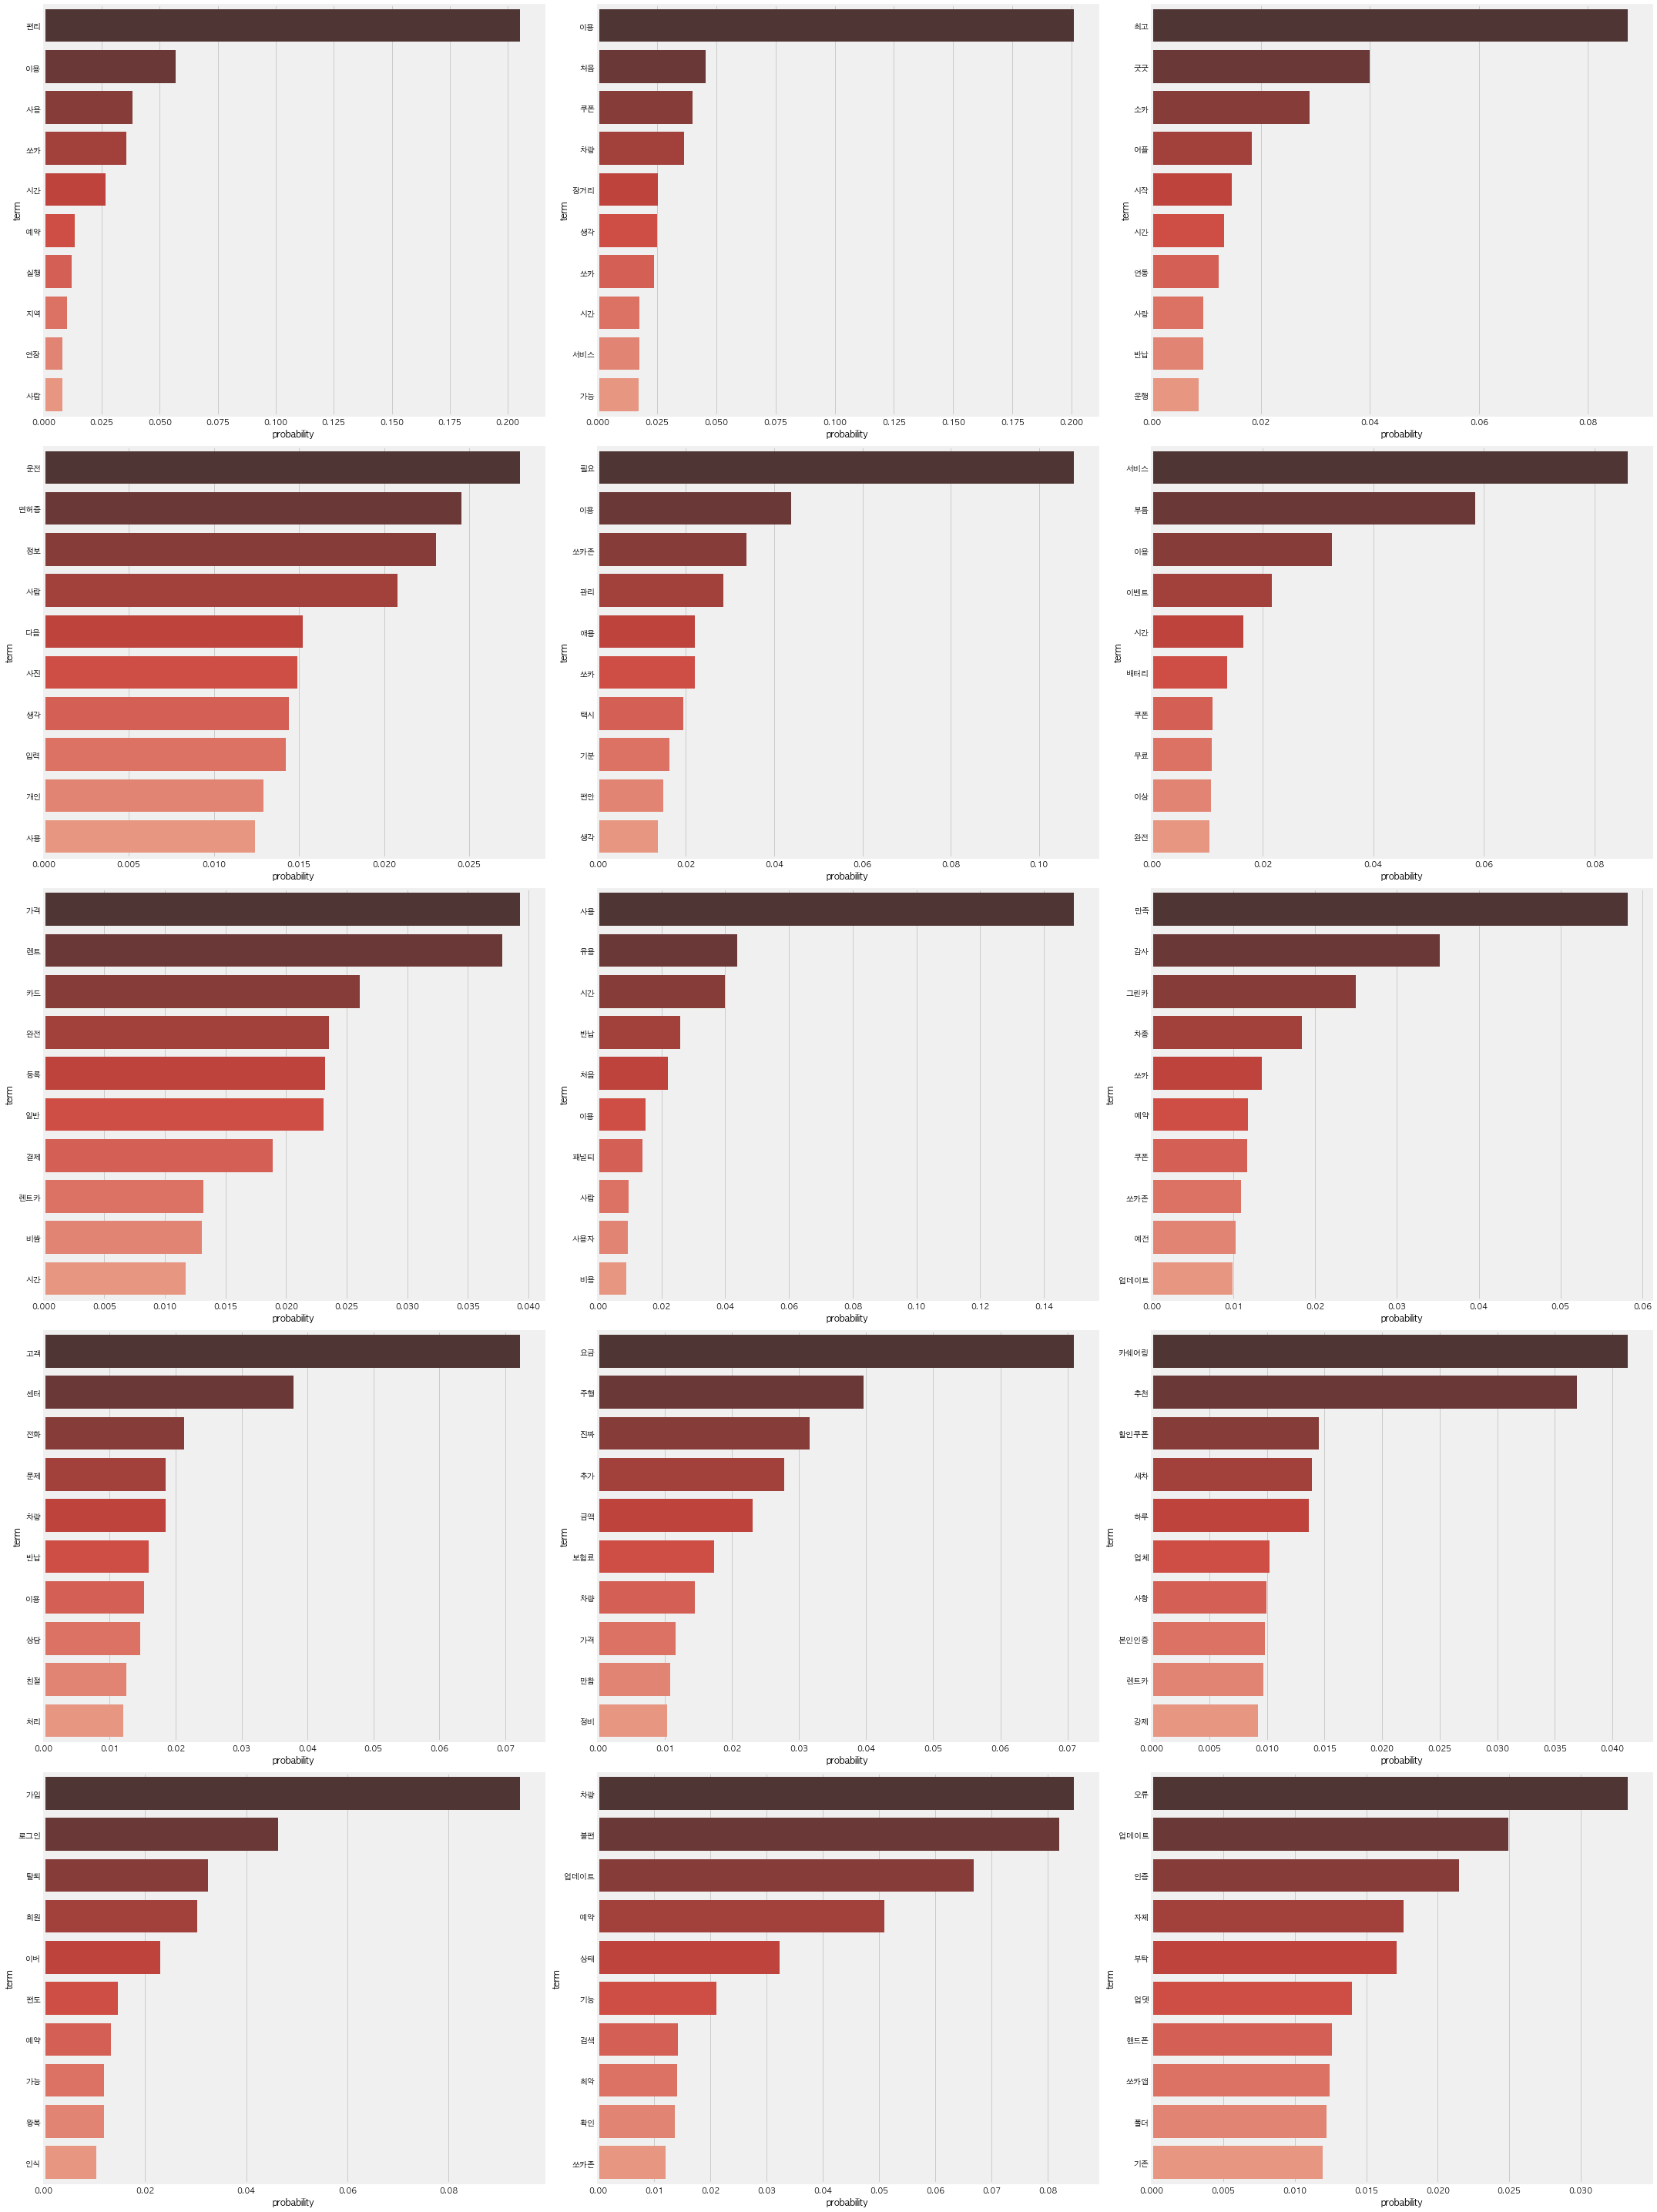

In [52]:
# run Topic modeling
make_lda_model_with_news(extracted_user_comment_noun_list, 15, 'all_rating')

- 별점 2점 이하일 경우에 대한 분석 

In [53]:
# get user_comment_noun_list of all rating reviews

user_comment_list = arranged_user_review_df[arranged_user_review_df['user_app_rating'] <= 2]['user_comment'].tolist()
extracted_user_comment_noun_list = execute_khaiii(user_comment_list)

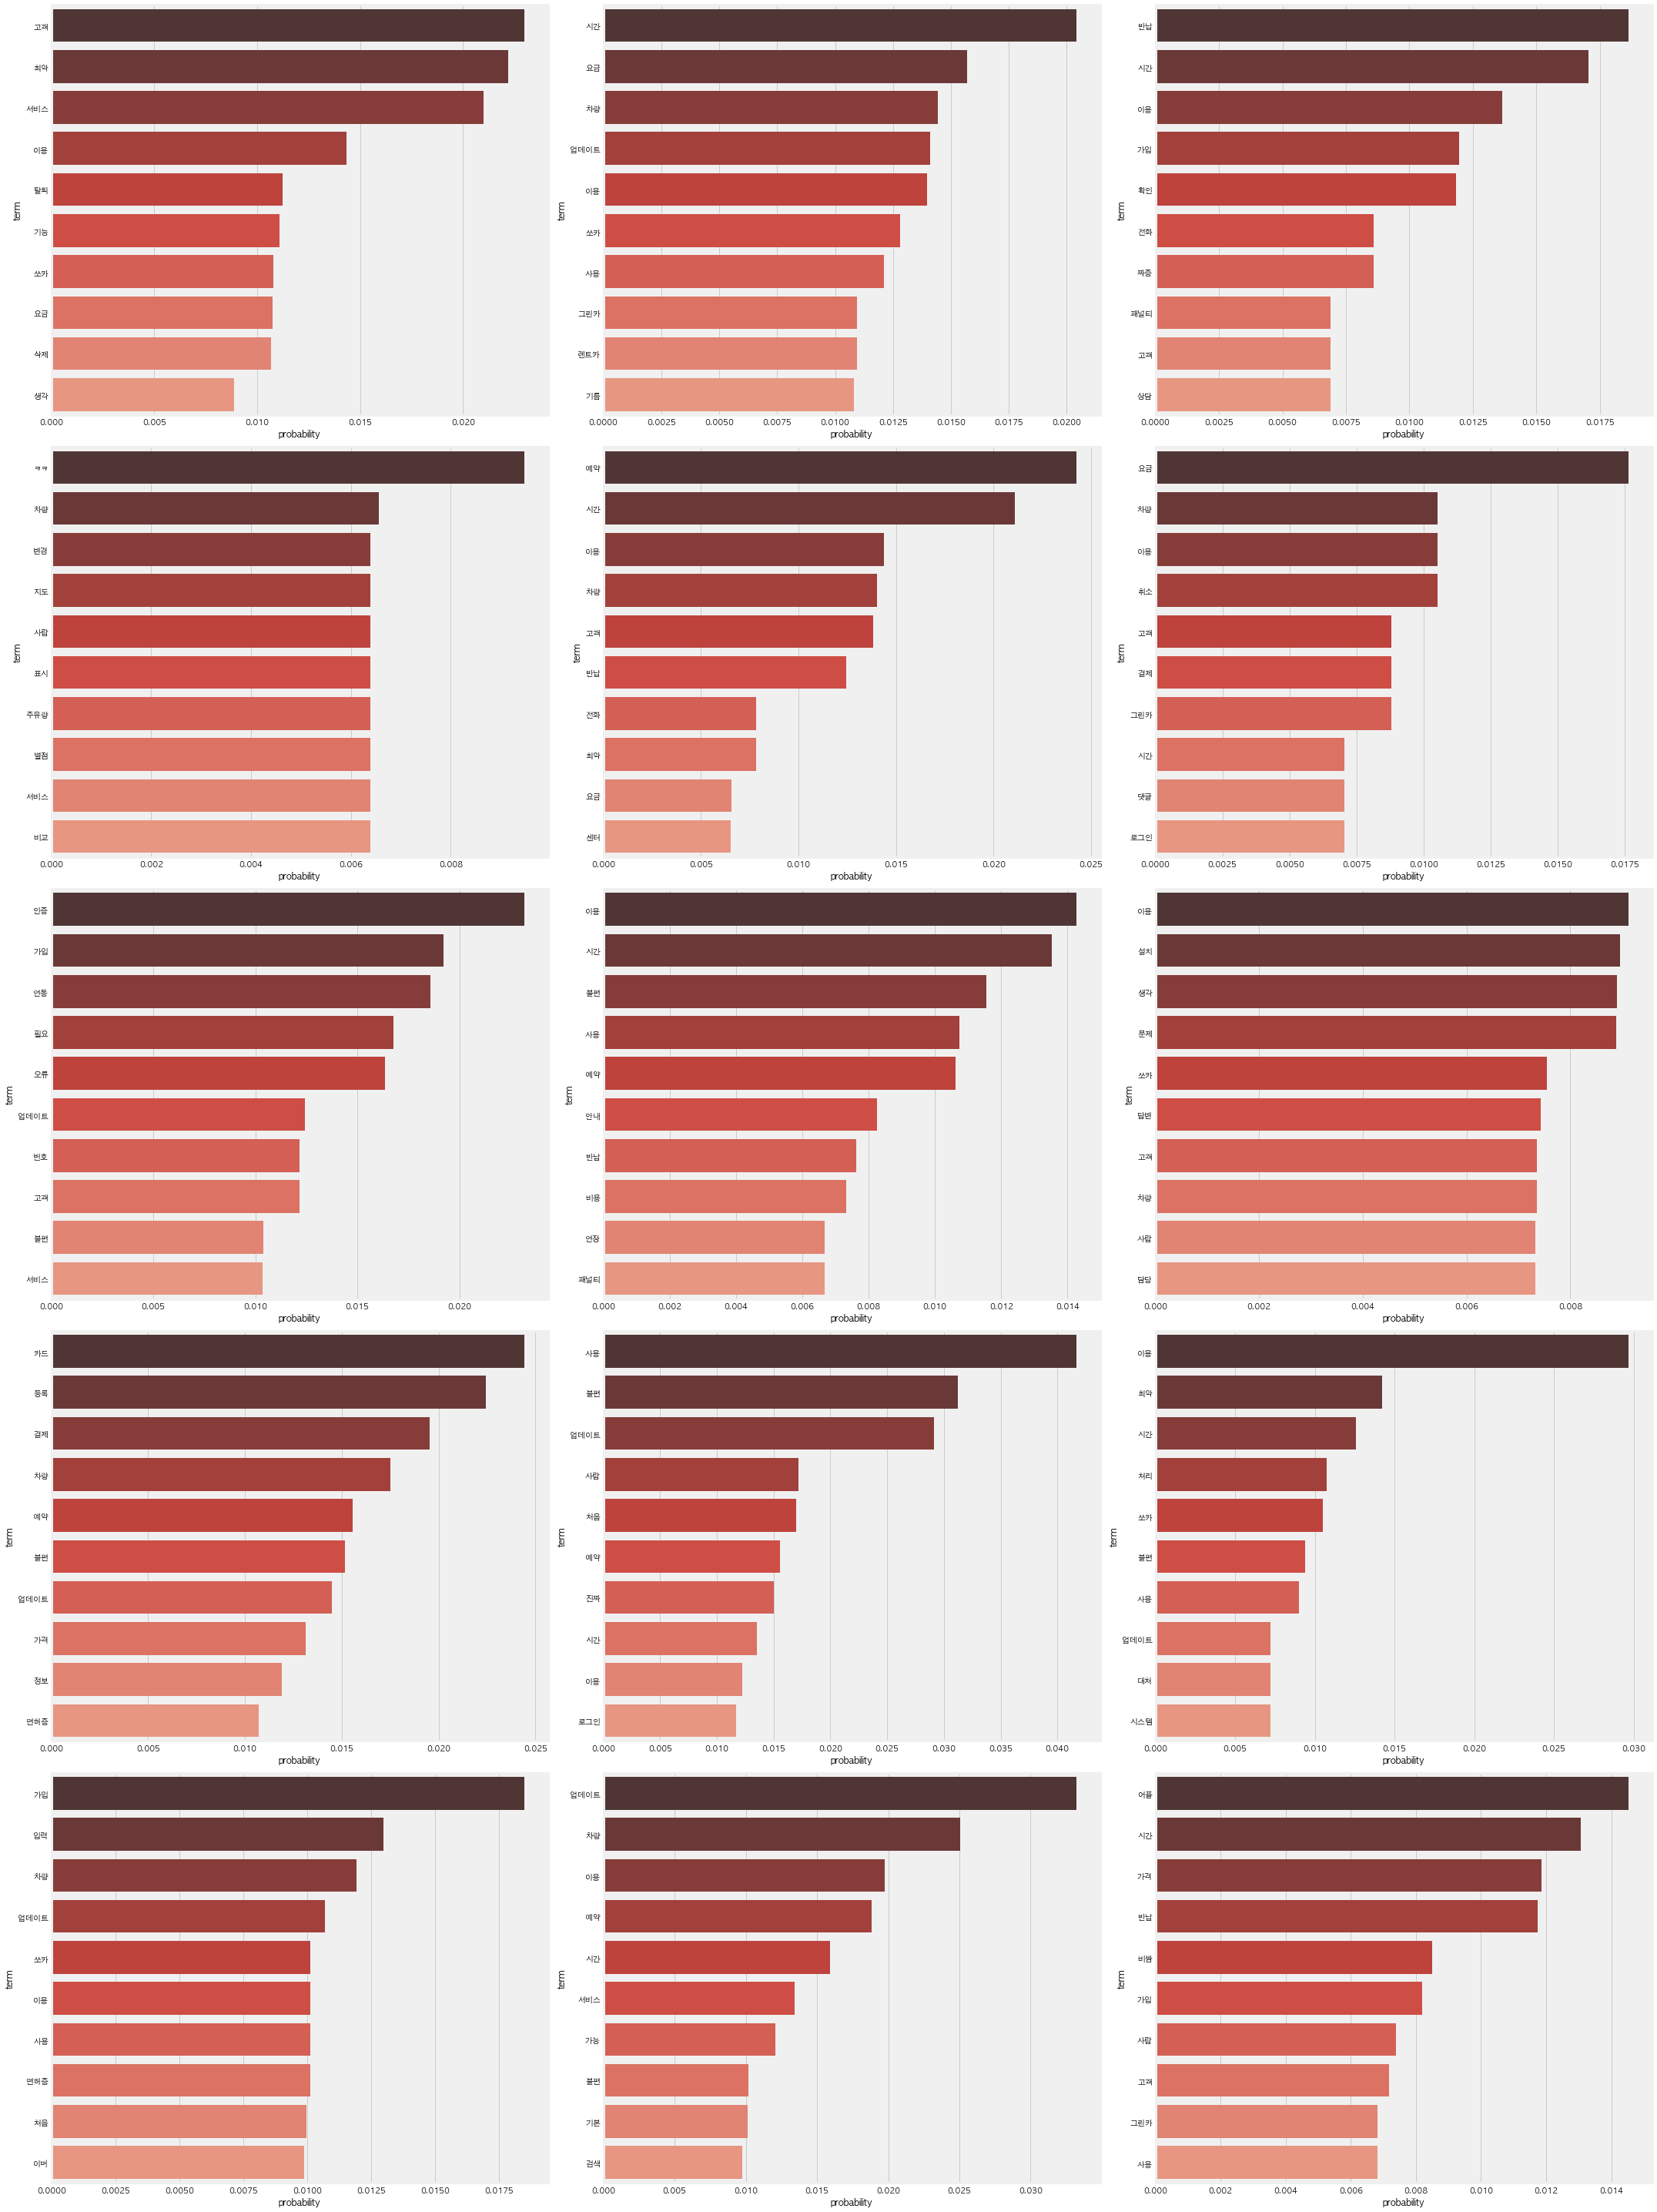

In [54]:
# run Topic modeling
make_lda_model_with_news(extracted_user_comment_noun_list, 15, 'low_rating')

In [63]:
# import operator
# sorted_x = sorted(kewword_dict.items(), key=operator.itemgetter(1), reverse=True)
# sorted_x